In [1]:
#pip install yellowbrick

In [5]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

#Import in xlsx file
Customer = pd.read_excel(r'\Wholesale customers data.xlsx')


In [19]:
#Look at data - visually look! 
#(may also open data frame in IDE to get a "cleaner" look)

#Look at the dataset dimensions
Customer.shape

#Check the variable types
Customer.info()

#Summary Statistics for dataset
SummaryResults = Customer.describe(include='all')

#Check for missing values
Customer.isnull() .sum()

#Remove categorical variables
Customer_reduc = Customer.drop(['Channel', 'Region'], axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [20]:
#Standardize the data
mms = MinMaxScaler()
mms.fit(Customer_reduc)
Customer_stdz = mms.transform(Customer_reduc)

In [21]:
Customer_reduc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicassen        440 non-null    int64
dtypes: int64(6)
memory usage: 20.8 KB


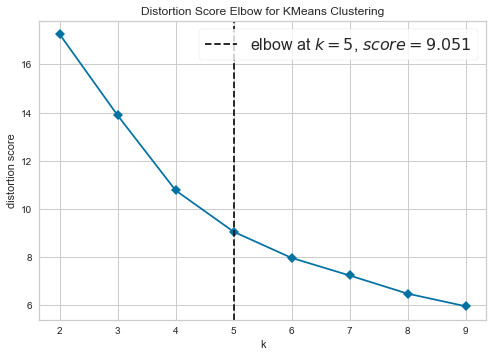

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
#Determine number of clusters and plot
#Elbow Method
model = KMeans(random_state=8675309)
visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(Customer_stdz)        
visualizer.show()

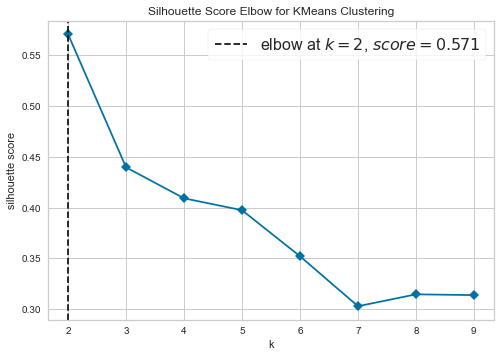

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [23]:
#Silhouette Method: lOOK for the max peak
model = KMeans(random_state=8675309)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False)
visualizer.fit(Customer_stdz)      
visualizer.show()

In [24]:
#Run cluster analysis 
Cluster_Count=5
kmeans = KMeans(n_clusters=Cluster_Count, random_state=8675309)
kmeans.fit(Customer_stdz)

Customer_Cluster = Customer_reduc
Customer_Cluster['cluster5'] = kmeans.predict(Customer_stdz)
centroids_5 = kmeans.cluster_centers_

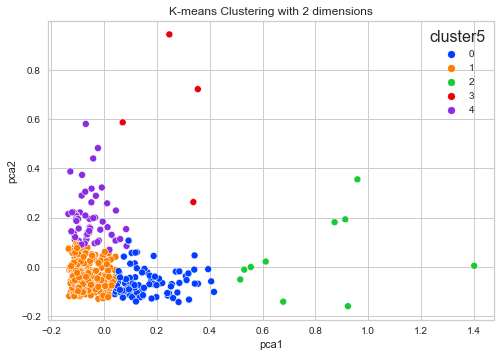

In [25]:
#Run PCA to visualize in 2 dimensions
Customer_PCA = PCA(n_components=2).fit_transform(Customer_stdz)
PCAresults = pd.DataFrame(Customer_PCA,columns=['pca1','pca2'])

palette = sns.color_palette("bright", Cluster_Count)
sns.scatterplot(x="pca1", y="pca2", legend = 'full', palette = palette, hue=Customer_Cluster['cluster5'], data=PCAresults)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [26]:
#Count observations in clusters
Customer_Cluster['cluster5'].value_counts()

1    277
0     90
4     59
2     10
3      4
Name: cluster5, dtype: int64

In [27]:
#Centroid distance
print(centroids_5)
#describes every cluster by there means
#Repeat above or write looping code to iterate over cluster numbers

[[0.04624415 0.14213305 0.18375424 0.02287818 0.18235542 0.03452533]
 [0.07820181 0.04080362 0.04121731 0.04559325 0.02461787 0.02158354]
 [0.14232889 0.47184211 0.52312427 0.04979291 0.60925436 0.06132249]
 [0.46384242 0.4308239  0.19927083 0.48978535 0.06603958 0.40995515]
 [0.30453402 0.06542143 0.06291083 0.0828607  0.02434718 0.04455888]]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

Recall Baseline: 1.0 Test: 0.4866071 Train: 0.99
Precision Baseline: 0.5 Test: 0.4898876 Train: 0.99
Roc Baseline: 0.5 Test: 0.4729649 Train: 1.0


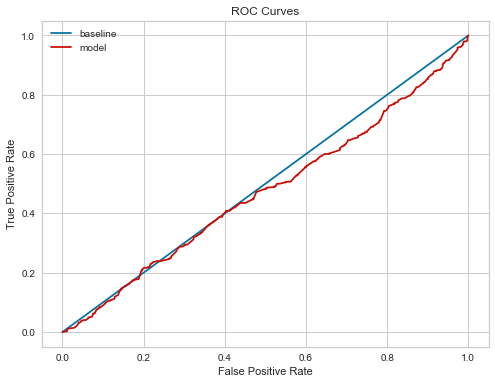

In [8]:
###################################################################
#Random Forest no cluster (Example where it does improve model - Stock data)
#Import Stock data

#Import in xlsx file
Stocks = pd.read_csv(r'\stock_data.csv')
Stocks['Y'] = Stocks['Y'].astype('category')

#Define evaluate model function
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 7)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    
# Extract the labels
labels = np.array(Stocks.pop('Y'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(Stocks, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = 8675309)

# Create the RF model
model = RandomForestClassifier(n_estimators=100, 
                               random_state=8675309, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]
#Evaluate Model   (see full code for evaluate_model function)
# ROC (Reciever operating characteristic curve) Baseline is the metric you compare
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [10]:
Stocks.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,91.567862,96.621901,98.084599,96.543909,91.678881,96.337918,96.1250,94.015957,94.409201,97.084183,...,97.292714,96.888889,95.499022,97.457971,99.282297,101.296698,98.310678,100.489134,99.602234,93.263158
2,92.908600,97.640753,103.112398,98.130312,78.041958,97.693843,95.6250,95.744681,94.089712,96.655229,...,95.093172,97.333333,96.379804,93.397222,100.478469,101.179953,98.141624,96.084839,99.204467,86.421053
3,84.869178,94.369892,109.018217,102.209632,73.357203,100.676878,96.9166,93.085106,98.243067,98.113343,...,97.461792,101.925926,95.988415,94.412410,100.956938,99.287025,102.027024,100.326263,103.985313,77.513179
4,88.888889,95.603221,108.459686,103.116147,77.832727,104.677398,100.8750,93.617021,100.000000,99.828542,...,102.537953,102.074074,102.152642,105.579469,106.937799,101.651101,103.884995,106.688139,108.525205,85.736842


In [ ]:
################
#Test Random Forest with Cluster
#Standardize the data
Stocks = pd.read_csv(r'\stock_data.csv')
Stocks['Y'] = Stocks['Y'].astype('category')

Stocks_noY = Stocks.drop(columns=['Y'])
mms = MinMaxScaler()
mms.fit(Stocks_noY)
Stocks_stdz = mms.transform(Stocks_noY)

#Run cluster analysis 
Cluster_Count=5
kmeans = KMeans(n_clusters=Cluster_Count, random_state=8675309)
kmeans.fit(Stocks_stdz)

Stocks_Cluster = Stocks
Stocks_Cluster['cluster5'] = kmeans.predict(Stocks_stdz)

Stocks_Cluster['cluster5'] = Stocks_Cluster['cluster5'].astype('category')
Stocks_Cluster = pd.get_dummies(Stocks_Cluster, columns = ['cluster5'])

# Extract the labels
labels = np.array(Stocks_Cluster.pop('Y'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(Stocks_Cluster, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = 8675309)

# Create the RF model
model = RandomForestClassifier(n_estimators=100, 
                               random_state=8675309, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

#Evaluate Model   
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [11]:
Stocks_Cluster

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X96,X97,X98,X99,X100,cluster5_0,cluster5_1,cluster5_2,cluster5_3,cluster5_4
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,0,0,1,0,0
1,91.567862,96.621901,98.084599,96.543909,91.678881,96.337918,96.1250,94.015957,94.409201,97.084183,...,101.296698,98.310678,100.489134,99.602234,93.263158,0,0,1,0,0
2,92.908600,97.640753,103.112398,98.130312,78.041958,97.693843,95.6250,95.744681,94.089712,96.655229,...,101.179953,98.141624,96.084839,99.204467,86.421053,0,0,1,0,0
3,84.869178,94.369892,109.018217,102.209632,73.357203,100.676878,96.9166,93.085106,98.243067,98.113343,...,99.287025,102.027024,100.326263,103.985313,77.513179,0,0,1,0,0
4,88.888889,95.603221,108.459686,103.116147,77.832727,104.677398,100.8750,93.617021,100.000000,99.828542,...,101.651101,103.884995,106.688139,108.525205,85.736842,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1186.510081,43.204252,198.997352,214.249292,225.174825,141.558554,36.5600,65.446809,140.319489,82.085820,...,279.227819,64.094508,241.330528,188.977281,12.530526,1,0,0,0,0
2996,1198.016409,44.096477,203.364465,216.487252,226.405594,142.990411,36.8800,66.000000,140.523962,81.385991,...,283.980987,64.783696,254.172257,195.593972,12.589474,1,0,0,0,0
2997,1193.656511,43.959212,204.947863,218.215298,228.453147,143.858203,37.1200,66.510638,143.488818,83.259062,...,286.899600,66.364775,260.071099,196.091180,12.538947,1,0,0,0,0
2998,1199.482215,44.611222,207.833733,219.235128,228.800000,144.313794,37.7200,66.829787,143.437700,84.267639,...,289.151101,66.689099,266.230953,196.703129,12.665263,1,0,0,0,0
